## import libraries

In [8]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [9]:
from MDAnalysis.lib.distances import calc_dihedrals
def calc_phi_psi(trajData):
    phis = calc_dihedrals(trajData[:,0,:], trajData[:,1,:], trajData[:,2,:], trajData[:,3,:])*180/3.14
    psis = calc_dihedrals(trajData[:,1,:], trajData[:,2,:], trajData[:,3,:], trajData[:,4,:])*180/3.14
    return phis,psis

## load all gmm objects

In [10]:
num_runs = 5 
num_weights = 4  # [uniform, bias, rbias, fbias]
num_sizes = 5    # [2,3,4,5,6]

# object array 
all_wsgmm = np.empty([num_runs, num_weights, num_sizes], dtype=object)

# init run, uniform weights -->
for i in range(num_sizes):
    with open("../bf10/run_with_v1.6.1/wsgmm_%dstate_wout_weights_nattempts_40.pickle"%(i+2), "rb")as fo:
        all_wsgmm[0,0,i] = pickle.load(fo)
        
# init run, bias, rbias and fbias weights -->
for i in range(num_weights-1):
    for j in range(num_sizes):
        with open("../bf10/w%d/run_with_v1.6.1/kabsch_thresh_1e-1/wsgmm_%dstate_nattempts_40.pickle"%(i+1,j+2), "rb") as fo:
            all_wsgmm[0,i+1,j] = pickle.load(fo)

# now load for all the other runs
for i in range(1,num_runs):
    for j in range(num_weights):
        for k in range(num_sizes):
            with open("r%d/w%d/wsgmm_%dstate_nattempts_40.pickle"%(i,j,k+2), "rb") as fo:
                all_wsgmm[i,j,k] = pickle.load(fo)

print(all_wsgmm.shape)

(5, 4, 5)


In [11]:
for i in range(num_runs):
    for j in range(num_weights):
        for k in range(num_sizes):
            print(all_wsgmm[i,j,k].log_likelihood)

41.591573728963354
53.20069885246669
53.4897307504339
53.788618536557884
53.62826287882732
57.23005912199342
58.235303126591255
58.95130136550523
59.63538277609147
60.0833932190874
57.12944267722715
58.51995554639225
59.17906604246575
59.67818574475605
59.55471881066154
57.192209164356974
58.54904661231582
58.878152558977206
59.550349913637426
59.61031694902154
51.2397436853373
53.34998097130129
53.162564230702074
53.613603159642125
53.68568460962017
54.902384996709
58.29776700370297
59.130244091821886
59.25666644253565
59.570812403798335
57.05120372905878
58.45178179195621
58.92117946125169
59.325142140711066
59.56313965191472
54.912999788980855
58.367097592922306
59.06151625547708
59.58307216981783
59.99646598871591
37.717608894730404
52.24157644200804
52.22868077953173
53.34549880291576
53.87433370723831
54.85973692004727
58.5357562517175
59.1372853920261
59.58236750642638
59.7268889756873
56.55742684040017
58.18685684297736
59.20237787573401
59.57826659443263
59.568497157399754
57.

## load the metad FE profiles from different runs (obtained using sum hills)

In [12]:
all_metad_fe_sumhills = np.empty([num_runs, 100, 100])

all_metad_fe_sumhills[0] = np.loadtxt("../bf10/2d_fe_phi_psi_sum_hill_bf10_nbins_100.txt", usecols=2).reshape((100,100))

for i in range(1, num_runs):
    all_metad_fe_sumhills[i] = np.loadtxt("r%d/2d_fe_phi_psi_sum_hill_bf10_nbins_100.txt"%i, usecols=2).reshape((100,100))

## check the FES from GMM objects (using MV generator) 

## calculate JSD and RMSE vs. number of clusters (with errorbars)

In [14]:
def numerical_integration_2d_simp(fxy,dx,dy):
    #dx and dy could be backwards, but probably identical here
    int_x = np.array([ np.trapz(fxy_i,dx=dx) for fxy_i in fxy ])
    return np.trapz(int_x,dx=dy)

In [16]:
nbins = [100,100]
kt = 0.596161 # @300K in kcal/mol unit
range_ = [-180,180]
n_frames = 1000000

all_wsgmm_fe_data = np.empty([num_runs, num_weights, num_sizes, 100, 100])
jsd_data = np.empty(all_wsgmm.shape)

for i in range(num_runs):
    
    dx = dy = 2*np.pi/len(all_metad_fe_sumhills[i])
    prob_metad = np.exp(-all_metad_fe_sumhills[i]/kt)
    prob_metad = prob_metad/numerical_integration_2d_simp(prob_metad,dx,dy)
    
    for j in range(num_weights):
        for k in range(num_sizes):
            
            # generate frames
            traj = all_wsgmm[i,j,k].generate(n_frames)
            
            # calculate dihedrals
            phis, psis = calc_phi_psi(traj)
            
            # histogram
            hist = np.histogram2d(phis, psis, bins=nbins, range=[range_, range_], density=True)[0]
            
            # store the free energy for RMSE calculation
            fe = -kt*np.log(hist)
            fe -= fe.min()
            all_wsgmm_fe_data[i,j,k] = fe
            
            hist = hist/numerical_integration_2d_simp(hist,dx,dy)
            
            # calcaulate JSD
            m = 0.5*(hist.flatten() + prob_metad.T.flatten())
            
            ar = np.nonzero(hist.flatten())
            jsd_data[i,j,k] = np.sum(hist.flatten()[ar]*(np.log(hist.flatten()[ar])-np.log(m[ar])))
            
            ar = np.nonzero(prob_metad.T.flatten())
            jsd_data[i,j,k] += np.sum(prob_metad.T.flatten()[ar]*(np.log(prob_metad.T.flatten()[ar])-np.log(m[ar])))
            
            jsd_data[i,j,k] *= dx*dy/(2*np.log(2))

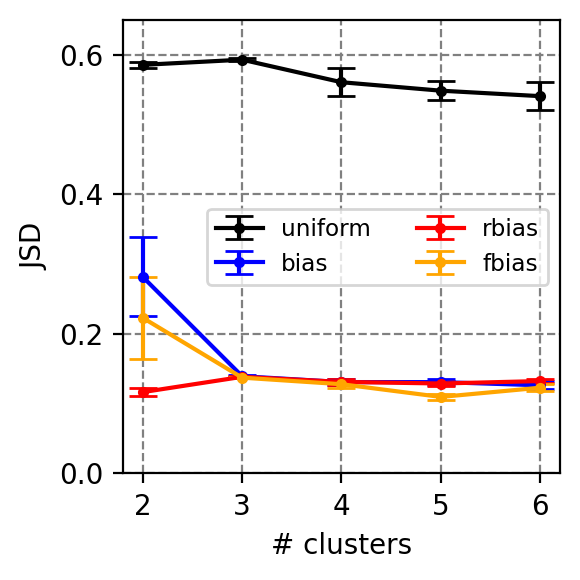

In [22]:
#markers = ['x','o','s','+']
colors = ['black','blue','red','orange']
plt.figure(figsize=(3, 3), dpi=200)
plt.xticks(np.arange(2,7))
plt.yticks(np.arange(0,1.2,0.2))
#plt.ylim(0,1)
plt.ylim(0,0.65)

plt.ylabel("JSD")
plt.xlabel("# clusters")
plt.grid(axis="both", which="major", linestyle="--", color="#808080")
labels=["uniform", "bias", "rbias", "fbias"]

for i in range(num_weights):
    plt.errorbar(np.arange(2,7), np.mean(jsd_data[:,i,:], axis=0), np.std(jsd_data[:,i,:], axis=0)/np.sqrt(num_runs), marker='.', color=colors[i], capsize=5.0, label=labels[i])
plt.legend(loc="center right", fontsize="small", ncol=2)
plt.tight_layout()

plt.savefig("jsd_data_with_error_bars.pdf", format="pdf")

In [19]:
rmse_data = np.empty(all_wsgmm.shape)

for i in range(num_runs):
    for j in range(num_weights):
        for k in range(num_sizes):
            
            gmm_fes = np.where(np.isfinite(all_wsgmm_fe_data[i,j,k].T), all_wsgmm_fe_data[i,j,k].T, 0).flatten()
            ref_fes = np.where(np.isfinite(all_wsgmm_fe_data[i,j,k].T), all_metad_fe_sumhills[i], 0).flatten()
        
            dE = gmm_fes - ref_fes
            dE = np.where(np.isfinite(dE), dE, 0)
            
            rmse_data[i,j,k] = np.sqrt(np.mean(np.square(dE)))

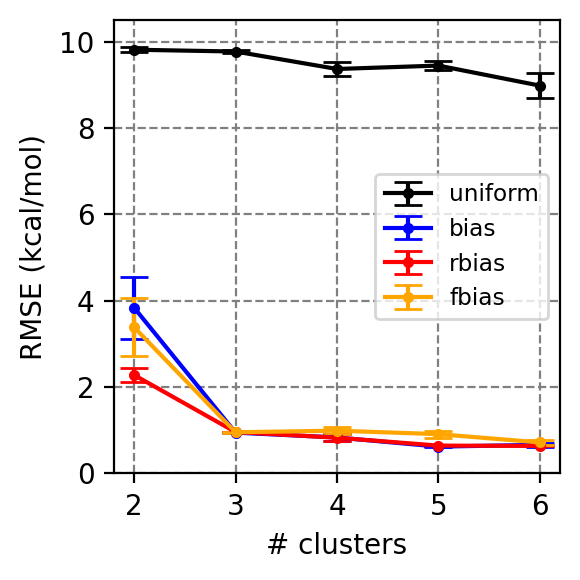

In [20]:
#markers = ['x','o','s','+']
colors = ['black','blue','red','orange']
plt.figure(figsize=(3, 3), dpi=200)
plt.xticks(np.arange(2,7))
plt.yticks(np.arange(0,12,2))
plt.ylim(0,10.5)
#plt.ylim(0,6)

plt.ylabel("RMSE (kcal/mol)")
plt.xlabel("# clusters")
plt.grid(axis="both", which="major", linestyle="--", color="#808080")
labels=["uniform", "bias", "rbias", "fbias"]

for i in range(num_weights):
    plt.errorbar(np.arange(2,7), np.mean(rmse_data[:,i,:], axis=0), np.std(rmse_data[:,i,:], axis=0)/np.sqrt(num_runs), marker='.', color=colors[i], capsize=5.0, label=labels[i])
plt.legend(loc="center right", fontsize="small")
plt.tight_layout()

plt.savefig("rmse_fe_data_with_error_bars.pdf", format="pdf")

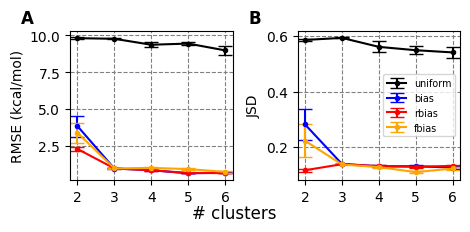

In [60]:
import string

fig, axs = plt.subplots(1, 2, sharex=True, figsize=(4.7,2.2))
fig.supxlabel("# clusters")
colors = ['black','blue','red','orange']
labels=["uniform", "bias", "rbias", "fbias"]

#0
axs[0].text(-0.30, 1.05, string.ascii_uppercase[0], fontsize=12, fontweight="bold", transform=axs[0].transAxes)
axs[0].set_ylabel("RMSE (kcal/mol)")
axs[0].set_xticks(np.arange(2,7))
axs[0].grid(axis="both", which="major", linestyle="--", color="#808080")
for i in range(num_weights):
    axs[0].errorbar(np.arange(2,7), np.mean(rmse_data[:,i,:], axis=0), np.std(rmse_data[:,i,:], axis=0)/np.sqrt(num_runs), marker='.', color=colors[i], capsize=5.0, label=labels[i])

    
#1
axs[1].text(-0.30, 1.05, string.ascii_uppercase[1], fontsize=12, fontweight="bold", transform=axs[1].transAxes)
axs[1].set_ylabel("JSD")
axs[1].set_xticks(np.arange(2,7))
axs[1].grid(axis="both", which="major", linestyle="--", color="#808080")
for i in range(num_weights):
    axs[1].errorbar(np.arange(2,7), np.mean(jsd_data[:,i,:], axis=0), np.std(jsd_data[:,i,:], axis=0)/np.sqrt(num_runs), marker='.', color=colors[i], capsize=5.0, label=labels[i])
axs[1].legend(fontsize="x-small", ncol=1)

fig.subplots_adjust(left=0.15, right=0.98, wspace=0.4, bottom=0.2)
plt.savefig("rmse_and_jsd_figure_horizontal.pdf", format="pdf")